# 1. Property Prediction - 化合物の水溶解度予測

分子構造は、元素とその位置、つまり3次元立体構造データとして表現されます。本ノートブックでは、DGL-LifeSciを用いて、分子構造のデータをそのまま入力して物質の物性値を予測するタスク（Property Prediction）を行います。
- 本ノートブックでは、分子構造に基づいて低分子化合物の水への溶解度予測を行います。本章で扱うデータは、ESOLのデータセットです。[ESOL（Estimated SOLubility）](https://pubs.acs.org/doi/10.1021/ci034243x)のデータセットは、化合物の水への溶解度に関するパブリックデータセットです（元論文の著者名から「Delaneyデータセット」とも呼ばれることがあります）。[MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a)と呼ばれる分子機械学習ベンチマークデータセットのうちの一つで、1128の化合物のデータが含まれています。
- 今回扱うタスクは、入力となる化合物の水への溶解度の数値を予測する問題（回帰問題, Regression Task）となります。

## 1.1. Using pre-trained model
- 例えば「試しに予測してみたい化合物はあるけれどGNNを1から学習させるのはハードルが高い...」という方もいらっしゃるかと思います。
- DGL-LifeSciではいくつかの有名なデータセットを用いて事前に学習されたモデルを提供しています。（一覧はこちら https://lifesci.dgl.ai/api/model.pretrain.html#api ）
- 1.1では事前学習済みモデルを用いることで、手元で機械学習のトレーニングを行うことなく、すぐに分子特性予測を行うことを体感します。

### Requirements
DGL-LifeSciおよび必要なライブラリをインストールします。
- DGL-LifeSci
- Python 3.6+
- PyTorch 1.5.0+
- DGL 0.7.0+
- RDKit 2018.09.3

In [15]:
!pip install dgl
!pip install dgllife
!conda install -c rdkit -y rdkit==2018.09.3

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rdkit==2018.09.3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.10.11 |       h06a4308_0         124 KB
    certifi-2021.5.30          |   py36h06a4308_0         139 KB
    conda-4.10.3               |   py36h06a4308_0         2.9 MB
    libboost-1.67.0            |       h46d08c1_4    

### Inference with pre-trained model
ESOLのデータセットで事前に学習されたモデルをロードします。

In [7]:
import torch
from dgllife.data import ESOL
from dgllife.model import load_pretrained
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer

model = load_pretrained('GCN_canonical_ESOL') # Pretrained model loaded

Pretrained model loaded


ではロードしたモデルの構造を見てみましょう。 （ちなみに本来`model.eval()`は、モデルを推論モードに切り替えるためのものです。）

In [6]:
model.eval()

GCNPredictor(
  (gnn): GCN(
    (gnn_layers): ModuleList(
      (0): GCNLayer(
        (graph_conv): GraphConv(in=74, out=128, normalization=none, activation=<function relu at 0x7f80bbb278c8>)
        (dropout): Dropout(p=0.0004181672129021179, inplace=False)
        (res_connection): Linear(in_features=74, out_features=128, bias=True)
      )
    )
  )
  (readout): WeightedSumAndMax(
    (weight_and_sum): WeightAndSum(
      (atom_weighting): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=True)
        (1): Sigmoid()
      )
    )
  )
  (predict): MLPPredictor(
    (predict): Sequential(
      (0): Dropout(p=0.0004181672129021179, inplace=False)
      (1): Linear(in_features=256, out_features=1024, bias=True)
      (2): ReLU()
      (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Linear(in_features=1024, out_features=1, bias=True)
    )
  )
)

次にデータセットをロードします。ここには学習に用いられた1128個の化合物に関するデータが含まれています。

In [15]:
dataset = ESOL(smiles_to_bigraph, node_featurizer=CanonicalAtomFeaturizer())

Processing dgl graphs from scratch...
Processing molecule 1000/1128


試しに、ロードしたデータセットの中から一つ選び、中身を見てみましょう。

In [24]:
smiles, g, label = dataset[0]
print('SMILES: ', smiles)
print('DGLGraph: ', g)
print('Node Features: ',g.ndata['h'], g.ndata['h'].size())
print('Label: ', label)

SMILES:  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
DGLGraph:  Graph(num_nodes=32, num_edges=68,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={})
Node Features:  tensor([[1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]) torch.Size([32, 74])
Label:  tensor([-0.7700])


各出力は以下のような意味となります。
- SMILES：対象としている化合物をSMILES記法で表した文字列
- DGLGraph：化合物をグラフ形式（DGLGraph）で表したオブジェクト
    - Node Features： 分子内の原子（グラフにおけるノード）に関係する特徴量の集まり。その原子が何か、隣接する水素原子の数など、各原子に関わる情報を数値化したものになります。（今回使用している`CanonicalAtomFeaturizer`についてはこちらをご覧ください https://lifesci.dgl.ai/generated/dgllife.utils.CanonicalAtomFeaturizer.html)
- Label: 予測すべき値となる水溶解度(logS = $\log_{10} \frac{mol}{L}$)を表しています。

選択された化合物の構造をRDKitを用いて確認してみましょう。

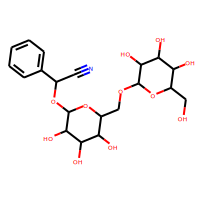

In [25]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw

mol = [Chem.MolFromSmiles(smiles)]
SVG(Draw.MolsToGridImage(mol, molsPerRow=1, useSVG=True))

では、選択された化合物に対して、事前に学習されたモデルを用いて水溶解度を予測していきます。

In [26]:
# Pop the node features
feats = g.ndata.pop('h')

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    label_pred = model(g, feats)

# Mask non-existing labels
print(label_pred)

tensor([[-1.2211]])


## 1.2. Train your own model on a CSV Dataset

- 実際に分子特性予測を行う場合、皆さんがそれぞれお持ちのカスタムデータセットを使ったモデルの作成を検討されると思います。
- DGL-LifeSciには、学習に使いたいデータ（CSVファイル）で用意していただければ、コマンドライン一行でモデルの学習 / 推論ができるプログラムが用意されています。
- 本節ではDGL-LifeSciが提供するプログラムを用いて化合物の水溶解度を予測するモデルの学習・推論を行います。

本ハンズオンでは、化合物の水溶解度に関するCSVデータとして、1.1でも使用したESOLデータセットを使用します。もしお手持ちのデータでモデルの学習ないし推論を試したい場合は、以下で説明する形式のCSVファイルを作成してください。

### Prepare a CSV Dataset

まずは対象データをCSV形式で準備する必要があります。ESOLデータセットをダウンロードします。

In [34]:
from dgl.data.utils import download, _get_dgl_url, extract_archive

url = 'dataset/ESOL.zip'
data_path = 'ESOL.zip'
download(_get_dgl_url(url), path=data_path)
extract_archive(data_path, './ESOL')

Extracting file to ./ESOL


In [37]:
import pandas as pd

df = pd.read_csv('ESOL/delaney-processed.csv')
df.head(10)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1
5,benzothiazole,-2.733,2,135.191,0,2,0,12.89,-1.50,c2ccc1scnc1c2
6,"2,2,4,6,6'-PCB",-6.545,1,326.437,0,2,1,0.00,-7.32,Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl
7,Estradiol,-4.138,1,272.388,2,4,0,40.46,-5.03,CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O
8,Dieldrin,-4.533,1,380.913,0,5,0,12.53,-6.29,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl
9,Rotenone,-5.246,1,394.423,0,5,3,63.22,-4.42,COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C


ダウンロードしたデータは上のようになっています。
複数あるカラムのうち、今回予測対象となる水溶解度は`measured log solubility in mols per litre`であり、`smiles`カラムが入力となるSMILES文字列となります。

### Download sample scripts

コマンドラインで実行できるプログラムはDGL-LifeSciの公式リポジトリにあります。まず、リポジトリをクローンします。

In [39]:
! git clone https://github.com/awslabs/dgl-lifesci.git

Cloning into 'dgl-lifesci'...
remote: Enumerating objects: 3145, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 3145 (delta 166), reused 282 (delta 133), pack-reused 2798
Receiving objects: 100% (3145/3145), 978.19 KiB | 0 bytes/s, done.
Resolving deltas: 100% (1907/1907), done.
Checking connectivity... done.
Checking out files: 100% (406/406), done.


In [139]:
%cp ./dgl-lifesci/examples/property_prediction/csv_data_configuration/ -r ./

/root/Yusmoris-dgllifesci-handson
ESOL/                               analysis_results/
ESOL.zip                            csv_data_configuration/
GCN_Tox21_pre_trained.pth           dgl-lifesci/
GCN_canonical_ESOL_pre_trained.pth  esol_dglgraph.bin
PropertyPrediction-ESOL.ipynb       regression_results/
PropertyPrediction.ipynb            tox21_dglgraph.bin


### Quick Analysis

まずはデータセットについて分析してみましょう。化合物について簡単に分析するためのスクリプトが用意されています。

In [140]:
!python ./csv_data_configuration/analysis.py -c ./ESOL/delaney-processed.csv -sc 'smiles' -p ./analysis_results

Using backend: pytorch
Directory ./analysis_results already exists.


In [141]:
!cat ./analysis_results/summary.txt

General statistics
Number of input molecules: 1128
Number of valid molecules: 1128
Percentage of valid molecules: 100.0 %
Average number of atoms per molecule: 13.289893617021276 +- 6.875553155518211
Average number of bonds per molecule: 13.677304964539006 +- 7.922527077263628
Average number of rings per molecule: 1.3909574468085106 +- 1.3177012832763317

Atom statistics
atom_type frequency: {'O': 725, 'C': 1128, 'N': 457, 'S': 116, 'Cl': 252, 'P': 43, 'F': 44, 'I': 16, 'Br': 50}
degree frequency: {1: 1060, 2: 1071, 3: 963, 4: 281, 0: 1}
total_degree frequency: {1: 740, 2: 621, 3: 912, 4: 884}
explicit_valence frequency: {1: 1018, 2: 844, 3: 934, 4: 920, 5: 43, 6: 25, 0: 1}
implicit_valence frequency: {0: 1017, 1: 966, 2: 660, 3: 728, 4: 1}
hybridization frequency: {'SP2': 920, 'SP3': 1010, 'SP': 39}
total_num_h frequency: {0: 1017, 1: 968, 2: 660, 3: 728, 4: 1}
formal_charge frequency: {0: 1128, 1: 59, -1: 59}
num_radical_electrons frequency: {0: 1128}
aromatic_atom frequency: {False:

### Train and Evaluate

In [143]:
%cd ./csv_data_configuration/
!python ./regression_train.py -c ../ESOL/delaney-processed.csv -sc 'smiles' -t 'measured log solubility in mols per litre' -me rmse -nw 0 -p ../regression_results

/root/Yusmoris-dgllifesci-handson/csv_data_configuration
Using backend: pytorch
Directory ../regression_results already exists.
Processing dgl graphs from scratch...
Processing molecule 1000/1128
Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/1128
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/1128
Use the manually specified hyperparameters
Created directory ../regression_results/28
For metric rmse, the lower the better
[2022-12-14 10:07:10.660 pytorch-1-6-cpu-py36--ml-t3-medium-e161cdcbc257f26c3e80f094dd8d:25160 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-14 10:07:10.736 pytorch-1-6-cpu-py36--ml-t3-medium-e161cdcbc257f26c3e80f094dd8d:25160 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
epoch 1/1000, batch 1/8, loss 2.7887
epoch 1/1000, training rmse 2.9970
epoch 1/1000, validation rmse 11.9685, best validation rmse 11.

よりモデル性能を向上させるため、モデルのハイパーパラメータの最適化を行います。
`-ne <num_trials>`のオプションを加えることで、`<num_trials>`で指定した回数分ハイパーパラメータの探索(ベイズ最適化)を行うことができます。

In [129]:
# With Hyper Parameter Search
%cd ../csv_data_configuration/
!python regression_train.py -ne 5 -c ../../../../ESOL/delaney-processed.csv -sc 'smiles' -t 'measured log solubility in mols per litre' -me rmse -nw 0 -p ../../../../regression_results

/root/Yusmoris-dgllifesci-handson/dgl-lifesci/examples/property_prediction/csv_data_configuration
Using backend: pytorch
Directory ../../../../regression_results already exists.
Processing dgl graphs from scratch...
Processing molecule 1000/1128
Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/1128
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/1128
Start hyperparameter search with Bayesian optimization for 5 trials
Created directory ../../../../regression_results/23                             
For metric rmse, the lower the better                                           
[2022-12-13 09:08:47.064 pytorch-1-6-cpu-py36--ml-t3-medium-e161cdcbc257f26c3e80f094dd8d:23893 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-13 09:08:47.136 pytorch-1-6-cpu-py36--ml-t3-medium-e161cdcbc257f26c3e80f094dd8d:23893 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. P

#### ToDo 
テストセット用CSVファイルを別に作って残しといてそれで推論

## 1.3 Train your own models using Amazon SageMaker Training Job

In [7]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session


sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'dgllifesci/esol/dataset'

role = get_execution_role()

In [87]:
# データをS3にアップロード
%cd ../
!aws s3 cp ./ESOL/delaney-processed.csv s3://{bucket}/{prefix}/delaney-processed.csv
!aws s3 ls s3://{bucket}/{prefix}/

/root/Yusmoris-dgllifesci-handson
upload: ESOL/delaney-processed.csv to s3://sagemaker-ap-northeast-1-233488627969/dgllifesci/esol/dataset/delaney-processed.csv
2022-12-13 04:26:01      96699 delaney-processed.csv


In [8]:
s3_input = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket}/{prefix}/delaney-processed.csv', content_type="csv")

In [9]:
!touch dgl-lifesci/examples/property_prediction/csv_data_configuration/requirements.txt
!echo "dgl-cu101 -f https://data.dgl.ai/wheels/repo.html\ndgllife\nrdkit-pypi" > dgl-lifesci/examples/property_prediction/csv_data_configuration/requirements.txt
!cat dgl-lifesci/examples/property_prediction/csv_data_configuration/requirements.txt

dgl-cu101 -f https://data.dgl.ai/wheels/repo.html
dgllife
rdkit-pypi


In [13]:
from sagemaker.pytorch import PyTorch
# import json
# # JSON encode hyperparameters
# def json_encode_hyperparameters(hyperparameters):
#     return {str(k): json.dumps(v) for (k, v) in hyperparameters.items()}

# hyperparameters = json_encode_hyperparameters(
#     {
#         'dataset':'Tox21',
#         'model':'GCN',
#         'featurizer-type':'canonical',
#         'sagemaker_program':'classification.py',
#         'sagemaker_submit_directory':inputs
#     }
# )

hyperparameters = {
    'csv-name': 'delaney-processed.csv',
    'model':'GCN',
    'atom-featurizer-type':'canonical',
    'smiles-column':'smiles',
    'task-names':"measured log solubility in mols per litre",
    'metric':'rmse',
    'num-workers': 0,
    'num-evals': 10,   
}

# Create estimator
estimator = PyTorch(
    entry_point="regression_train_sagemaker.py",
    source_dir="./csv_data_configuration/",
    role=role,
    framework_version="1.6.0",
    py_version="py3",
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters
)

In [14]:
# 学習を開始
estimator.fit({'train':s3_input})

2022-12-16 08:08:42 Starting - Starting the training job...
2022-12-16 08:09:07 Starting - Preparing the instances for trainingProfilerReport-1671178121: InProgress
.........
2022-12-16 08:10:29 Downloading - Downloading input data...
2022-12-16 08:11:07 Training - Downloading the training image...
2022-12-16 08:11:27 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-16 08:11:27,815 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-16 08:11:27,818 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-16 08:11:27,828 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-16 08:11:27,831 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-16 08:11:28,184 sagemaker-training-toolkit INFO     Insta

UnexpectedStatusException: Error for Training job pytorch-training-2022-12-16-08-08-40-798: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 regression_train_sagemaker.py --atom-featurizer-type canonical --csv-name delaney-processed.csv --metric rmse --model GCN --num-evals 10 --num-workers 0 --smiles-column smiles --task-names measured log solubility in mols per litre"
Traceback (most recent call last):
  File "regression_train_sagemaker.py", line 14, in <module>
    from dgllife.utils import Meter, EarlyStopping
  File "/opt/conda/lib/python3.6/site-packages/dgllife/__init__.py", line 9, in <module>
    from . import model
  File "/opt/conda/lib/python3.6/site-packages/dgllife/model/__init__.py", line 6, in <module>
    from .gnn import *
  File "/opt/conda/lib/python3.6/site-packages/dgllife/model/gnn/__init__.py", line 8, in <module>
    from .attentivefp import *
  File "/opt/conda/lib/python3.6/site-packages/dgllife/model/gnn/attentivefp.py", line 9, in <module>
    import dgl.function as fn
  File "/opt/conda/lib/python3.6/site-packages/dgl/__init__.py", line 13, in <

In [131]:
estimator.latest_training_job.job_name
# !aws s3 cp {estimator.output_path}{estimator.latest_training_job.job_name}/output/model.tar.gz .

'pytorch-training-2022-12-13-08-19-05-161'

## 1.4. Train your own models using Amazon SageMaker Training Job with Custom Container (※ Optional) 

#### メモ
- requirementの`RDKit 2018.09.3`がconda installでないとinstallできないので、document通りに確実に動く環境を整えるならこっち（のはず）。
- ただし`pip install rdkit-pypl`でも対応できる(2022年12月現在)。version 2018.09.3のものはサポートされていないが、dglaiの方のハンズオンではこれで対応している。

### Setup
SageMakerで学習を実行するにあたり必要なライブラリをインストールします。

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session


sess = sagemaker.Session()
bucket = sess.default_bucket()

role = get_execution_role()

In [ ]:
!pip install sagemaker-studio-image-build

In [ ]:
%%sh

docker_name=sagemaker-dgllifesci-py36
sm-docker build . -f ./container/Dockerfile --repository $docker_name:1.0

In [ ]:
!tar -czvf source.tar.gz utils.py classification.py ./configures

In [44]:
prefix = 'dgl-lifesci/property_prediction/code'
inputs = sess.upload_data(path='./source.tar.gz', bucket=bucket, key_prefix=prefix)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-ap-northeast-1-233488627969/dgl-lifesci/property_prediction/code/source.tar.gz


In [45]:
import json
# JSON encode hyperparameters
def json_encode_hyperparameters(hyperparameters):
    return {str(k): json.dumps(v) for (k, v) in hyperparameters.items()}

hyperparameters = json_encode_hyperparameters(
    {
        'dataset':'Tox21',
        'model':'GCN',
        'featurizer-type':'canonical',
        'sagemaker_program':'classification.py',
        'sagemaker_submit_directory':inputs
    }
)

estimator = sagemaker.estimator.Estimator(
    image_uri = '233488627969.dkr.ecr.ap-northeast-1.amazonaws.com/sagemaker-dgllifesci-py36:1.0',
    role = role,
    instance_count = 1,
    instance_type = "ml.m5.4xlarge",
    hyperparameters = hyperparameters,
    sagemaker_session = sess
)
estimator.fit()

2022-07-28 16:15:05 Starting - Starting the training job...
2022-07-28 16:15:29 Starting - Preparing the instances for trainingProfilerReport-1659024904: InProgress
......
2022-07-28 16:16:33 Downloading - Downloading input data...
2022-07-28 16:16:49 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-28 16:17:45,869 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-28 16:17:45,871 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-28 16:17:45,881 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-28 16:17:45,885 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-28 16:17:46,228 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-28 16:17:46,240 sagemaker-training-tool